In [47]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score as acc
from typing import List, Optional, Union, Tuple, Any, Callable
import numpy as np
from lime import explanation
from lime import lime_base
import math

In [2]:
from ts_explainer import LimeTimeSeriesExplainer, ShapTimeSeriesExplainer
import ts_explainer

In [3]:
class TimeSeriesKNN:
    def __init__(self, **kwargs):
        self.knn = KNN(**kwargs)

    def fit(self, X: List[np.array], y: np.array):
        self.size = min([arr.shape[1] for arr in X])

        self.knn.fit([arr[:, : self.size].ravel() for arr in X], y)

    def predict(self, X: List[np.array]):
        if isinstance(X, list) or len(X.shape) == 3:
            return self.knn.predict([arr[:, : self.size].ravel() for arr in X])
        else:
            return self.knn.predict(X.ravel()[None, :])

    def predict_proba(self, X: Union[np.array, List[np.array]]):
        if isinstance(X, list) or len(X.shape) == 3:
            return self.knn.predict_proba([arr[:, : self.size].ravel() for arr in X])
        else:
            return self.knn.predict_proba(X.ravel()[None, :])

In [4]:
X = np.load("../data/EEG_mental_state/dataset/X_train.npy")
Y = np.load("../data/EEG_mental_state/dataset/Y_train.npy")
X = X.transpose(0, 2, 1)

In [5]:
Y = (Y==-1) * 0 + (Y==0) * 1 +  (Y==1) * 2 

In [6]:
X = [arr for arr in X]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=100, random_state=42)

In [32]:
idx = 101
num_slices = 5  # split time series
explainable_sample = X_test[idx]
explainable_y = y_test[idx]

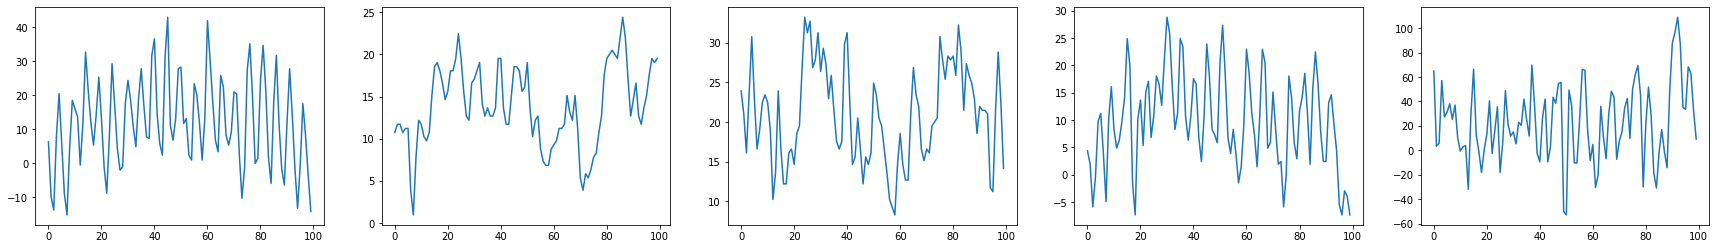

In [9]:
def plot_time_series(X):
    N = X.shape[0]
    fig, ax = plt.subplots(1, N, figsize=(30, 4))
    for i in range(N):
        ax[i].plot(np.arange(X.shape[1]), X[i, :])
    return fig, ax
    
plot_time_series(explainable_sample)
plt.show()

In [35]:
idx = 101 # explained instance
explainable_sample = X_test[idx]
explainable_y = 2 #y_test[idx]
num_features = 3
num_slices = 5
explainable_sample.shape, explainable_y

((5, 100), 2)

In [36]:
knn = TimeSeriesKNN(n_neighbors=10)
knn.fit(X_train, y_train)

In [37]:
knn.predict_proba(explainable_sample)

array([[0. , 0.1, 0.9]])

In [38]:
explainer = ShapTimeSeriesExplainer(knn.predict_proba, X_train, class_names=["-1", "0", "1"])
#explainer = LimeTimeSeriesExplainer(knn.predict_proba, class_names=["-1", "0", "1"])
exp = explainer.explain_instance(
    explainable_sample, 
    top_labels=3, 
    num_slices=num_slices, 
    num_samples=10000,
    num_features=num_features
)

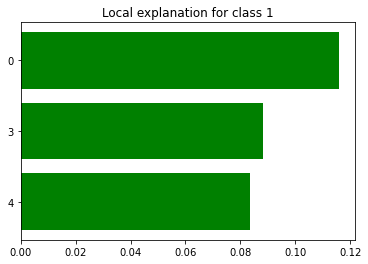

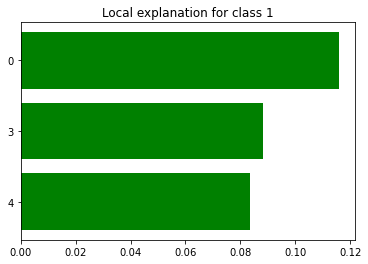

In [39]:
exp.as_pyplot_figure(label=explainable_y)

In [40]:
exp.as_list(label=explainable_y)

[(0, 0.11601055305126347), (3, 0.08821751978483638), (4, 0.08337286626617232)]

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:>]


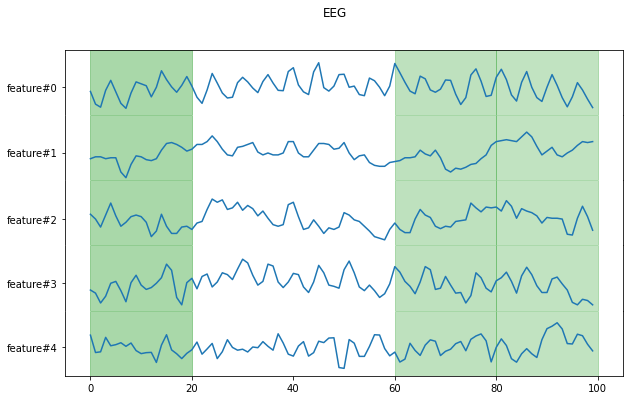

In [41]:
ts_explainer.plot_eeg(explainable_sample, num_slices,exp.as_list(label=explainable_y), title="EEG", figsize=(10,6))
plt.show()

In [197]:
cumulative_explanation = np.zeros(explainable_sample.shape[1])
for num_slices in range(2, 20):
    explainer = ShapTimeSeriesExplainer(knn.predict_proba, X_train, class_names=["-1", "0", "1"])
    #explainer = LimeTimeSeriesExplainer(knn.predict_proba, class_names=["-1", "0", "1"])
    exp = explainer.explain_instance(
        explainable_sample, 
        top_labels=3, 
        num_slices=num_slices, 
        num_samples=1000,
        num_features=num_slices
    )
    
    explanations = exp.as_list(label=explainable_y)
    values_per_slice = math.ceil(explainable_sample.shape[1] / num_slices)
    for feature, weight in explanations:
        start = feature * values_per_slice
        end = start + values_per_slice
        cumulative_explanation[start:end] += weight

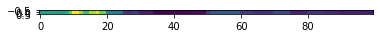

In [202]:
cumulative_explanation = cumulative_explanation/cumulative_explanation.max()
cumulative_explanation = cumulative_explanation**3
plt.imshow(cumulative_explanation[None, :])

In [203]:
cumulative_explanation

array([0.59764319, 0.59764319, 0.59764319, 0.59764319, 0.59764319,
       0.59764319, 0.59852493, 0.59342345, 0.63396394, 0.79230023,
       1.        , 1.        , 0.86030497, 0.69943164, 0.69369579,
       0.87494935, 0.86639712, 0.95294559, 0.79529074, 0.79529074,
       0.45620236, 0.45474764, 0.45474764, 0.45474764, 0.40722356,
       0.19542107, 0.18238402, 0.18423623, 0.20952659, 0.20952659,
       0.12007989, 0.12007989, 0.1203839 , 0.1203839 , 0.05987085,
       0.05185476, 0.04692387, 0.04692387, 0.04692387, 0.05356901,
       0.06203701, 0.06203701, 0.06158469, 0.06158469, 0.06158469,
       0.06927341, 0.06927341, 0.06927341, 0.07285771, 0.07384517,
       0.21633048, 0.28554909, 0.30483479, 0.30483479, 0.31108486,
       0.31108486, 0.32263342, 0.32263342, 0.32263342, 0.32263342,
       0.20769391, 0.20769391, 0.20769391, 0.20221955, 0.1833414 ,
       0.16702336, 0.16673298, 0.16673298, 0.18538619, 0.18538619,
       0.2568761 , 0.2568761 , 0.25306555, 0.25306555, 0.25306

In [204]:
def plot_eeg(
    X: np.array,
    num_slices: int,
    explanations: List[Tuple[int, float]],
    features_name: Optional[List[str]] = None,
    title: str = "",
    figsize: Tuple[int, int] = (10, 7)
):
    if features_name is None:
        features_name = [f"feature#{i}" for i in range(X.shape[0])]

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(X.shape[0], hspace=0)
    axes = gs.subplots(sharex=True, sharey=False)
    if not isinstance(axes, np.ndarray):
        axes = [axes] 
    fig.suptitle(title)
    for i, ax in enumerate(axes):
        ax.plot(np.arange(X.shape[1]), X[i, :])
        l, u = ax.get_ylim()
        ax.set_ylim(l - 0.3*abs(l), u + 0.3*abs(u))
        l, u = ax.get_ylim()

        # Set number of ticks for x-axis
        ax.set_yticks([X[i, :].mean()])
        ax.set_yticklabels([features_name[i]])

        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)

    axes[0].spines['top'].set_visible(True)
    axes[-1].spines['bottom'].set_visible(True)

    values_per_slice = int(cumulative_explanation.shape[0] / 19)
    for feature in range(19):
        start = feature * values_per_slice
        print(start)
        end = min(start + values_per_slice, cumulative_explanation.shape[0])
        color = '#d62728' if weight < 0 else '#2ca02c'
        for ax in axes:
            ax.axvspan(start, end, color=color, alpha=abs(cumulative_explanation[start]))
        
    return fig, axes


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90


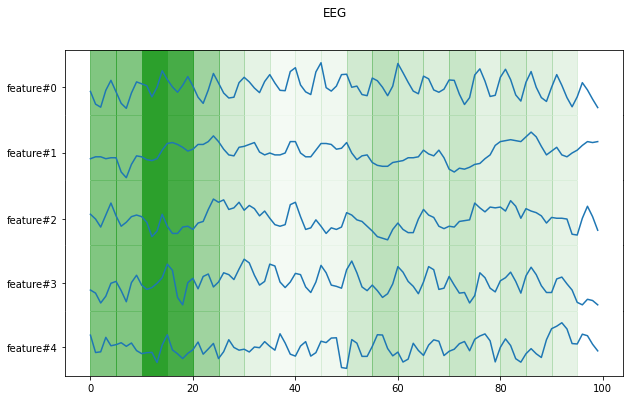

In [225]:
plot_eeg(explainable_sample, num_slices, exp.as_list(label=explainable_y), title="EEG", figsize=(10,6))
plt.show()